In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [3]:
# Load data
data = pd.read_csv('/Users/jakubsuszwedyk/Documents/University/Year_2/Project/Project_VSC_2/Project2-2/Project_2-2/NL_data/ams.csv')

In [4]:
# Convert 'time' to datetime and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)


In [5]:
# Run ADF test on the temperature data
result = adfuller(data['t2m'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print("Series is non-stationary and may need differencing.")
else:
    print("Series is stationary.")

ADF Statistic: -12.276161
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Series is stationary.


In [6]:
# Run KPSS test on the temperature data
result_kpss = kpss(data['t2m'], regression='c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

if result_kpss[1] < 0.05:
    print("Series is non-stationary based on KPSS test and may need differencing.")
else:
    print("Series is stationary based on KPSS test.")



KPSS Statistic: 0.523498
p-value: 0.036374
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is non-stationary based on KPSS test and may need differencing.


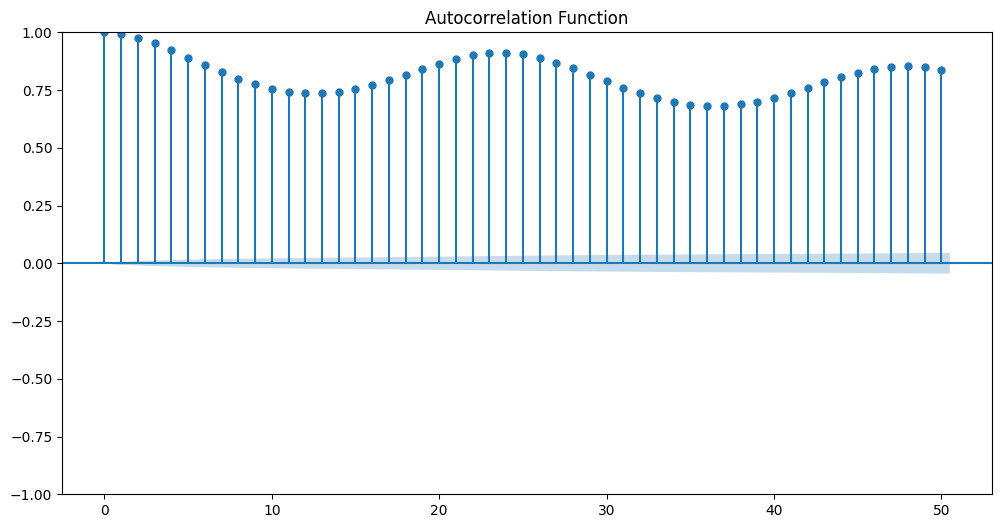

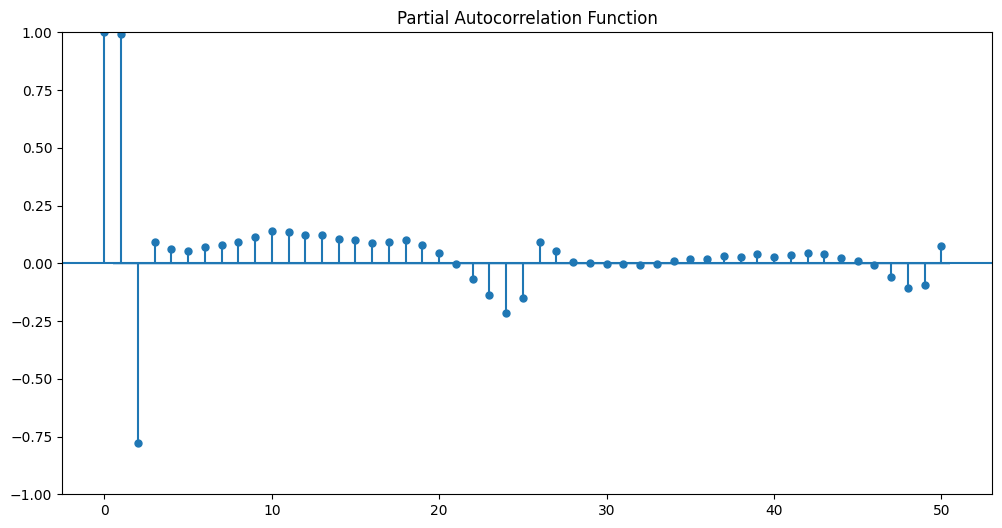

In [7]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(data['t2m'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(data['t2m'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.show()

In [8]:
# Create lagged features based on past temperature values
window_size = 3
for i in range(1, window_size + 1):
    data[f't2m_lag_{i}'] = data['t2m'].shift(i)

# Drop rows with NaN values
data = data.dropna()

In [9]:
# Split data into features and target
X = data[[f't2m_lag_{i}' for i in range(1, window_size + 1)]]
y = data['t2m']

In [10]:
# Split data into training and testing sets, no shuffle for time series data
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X.iloc[:train_size], X.iloc[train_size:train_size+val_size], X.iloc[-test_size:]
y_train, y_val, y_test = y.iloc[:train_size], y.iloc[train_size:train_size+val_size], y.iloc[-test_size:]



In [11]:
# Create and train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [12]:
# Evaluate on the validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)

Validation Mean Squared Error: 0.2407174832514256


In [13]:
# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)

Test Mean Squared Error: 0.21815487907495346


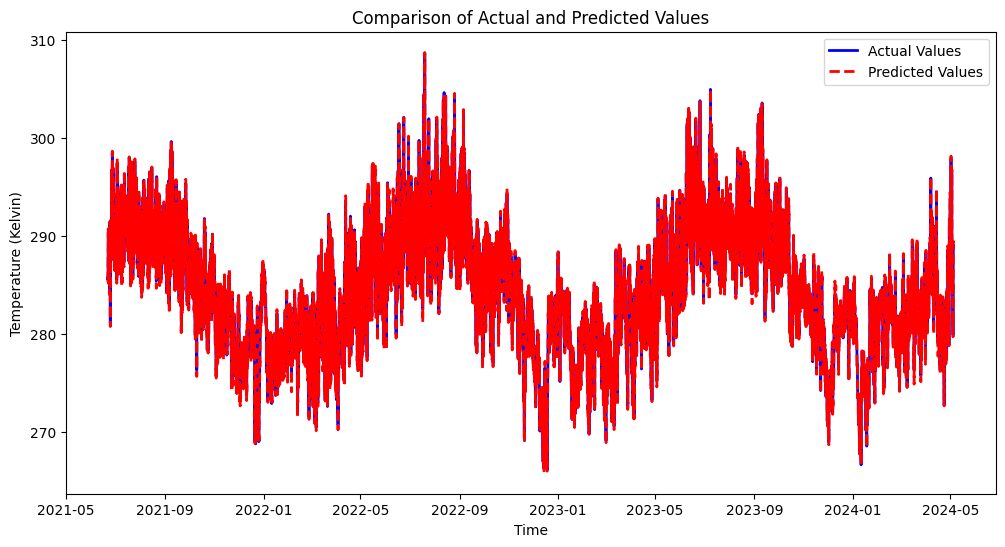

In [14]:
# Plotting Predicted vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, color='blue', label='Actual Values', linewidth=2)
plt.plot(y_test.index, y_test_pred, color='red', label='Predicted Values', linewidth=2, linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature (Kelvin)')
plt.legend()
plt.show()

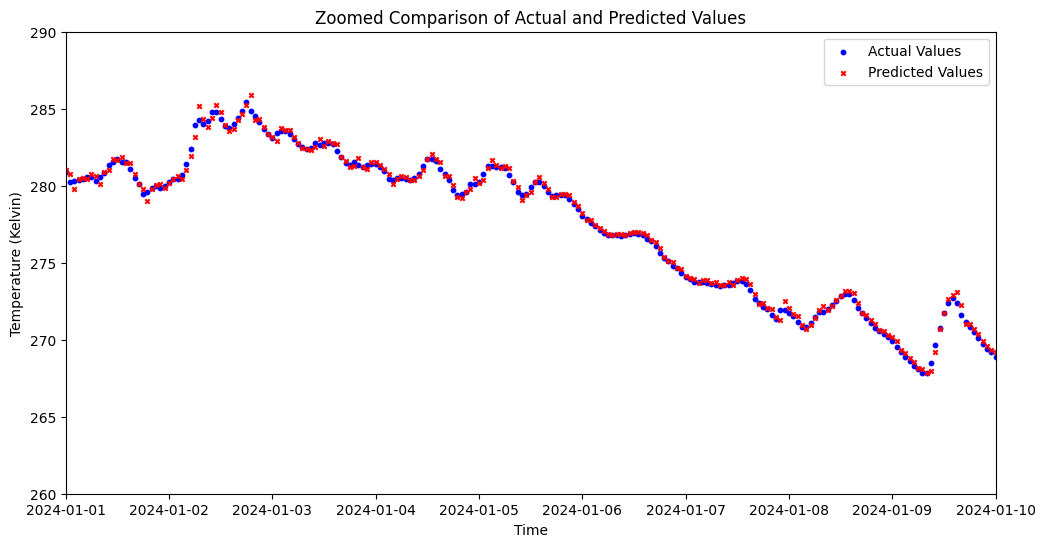

In [25]:
# Plotting Predicted vs Actual Values using points, zoomed in
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_test, color='blue', label='Actual Values', marker='o', s=10)  # using scatter for actual values
plt.scatter(y_test.index, y_test_pred, color='red', label='Predicted Values', marker='x', s=10)  # using scatter for predicted values

# Set the time range to zoom in on
zoom_start = pd.Timestamp('2024-01-01')  # specify the start date
zoom_end = pd.Timestamp('2024-01-10')    # specify the end date
plt.xlim(zoom_start, zoom_end)  # Adjust the x-axis to display a specific time range

# Set the temperature range to zoom in on
min_temp = 260
max_temp = 290
plt.ylim(min_temp, max_temp)  # Adjust the y-axis to focus on this temperature range

plt.title('Zoomed Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature (Kelvin)')
plt.legend()
plt.show()

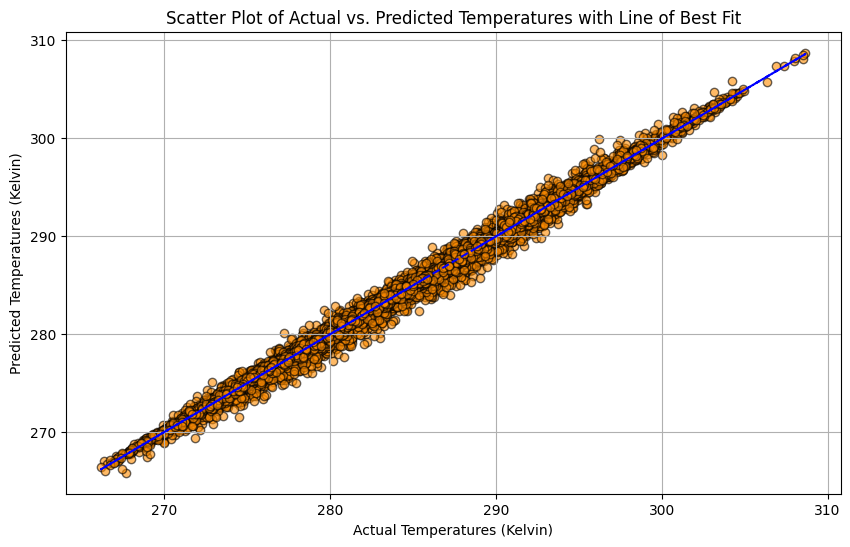

In [26]:
# Scatter plot with line of best fit for test set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='darkorange', edgecolors='k', alpha=0.6)
z = np.polyfit(y_test, y_test_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "b--")  # Optimal fit dashed line
plt.title('Scatter Plot of Actual vs. Predicted Temperatures with Line of Best Fit')
plt.xlabel('Actual Temperatures (Kelvin)')
plt.ylabel('Predicted Temperatures (Kelvin)')
plt.grid(True)
plt.show()